## Loading the libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (confusion_matrix, classification_report, roc_auc_score, roc_curve, 
                             precision_recall_curve, auc)
from imblearn.over_sampling import SMOTE

## Loading the dataset

In [4]:
# Loading the dataset
data = pd.read_csv('../Datasets/WA_Fn-UseC_-Telco-Customer-Churn.csv')

data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data pre-processing

In [7]:
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)

C:\Users\raghu\AppData\Local\Temp\ipykernel_31704\830575513.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  data['TotalCharges'].fillna(data['TotalCharges'].median(), inplace=True)


## Convert categorical variables using one-hot encoding

In [10]:
categorical_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                        'InternetService', 'OnlineSecurity', 'DeviceProtection', 'TechSupport',
                        'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']


ohe = OneHotEncoder(drop='first')
preprocessor = ColumnTransformer(transformers=[
    ('cat', ohe, categorical_features)], remainder='passthrough')




## Apply Pre-Processing - mapping churn to a binary column

In [40]:
X = data.drop(columns=['customerID', 'Churn'])
y = data['Churn'].map({'Yes': 1, 'No': 0})  # Map target to binary
X_processed = preprocessor.fit_transform(X)
X_processed[:, -3] = np.where(X_processed[:, -3] == 'Yes', 1, 0)

## Standardizing the numerical features

In [41]:
scaler = StandardScaler()
X_processed = scaler.fit_transform(X_processed)

## Split into train and test data

In [42]:
X_train, X_test, y_train, y_test =  train_test_split(X_processed, y, test_size=0.2, random_state=42)

## Oversampling to handle imbalance in dataset

In [43]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

## Visualize the effect of SMOTE 

## Before Oversampling

C:\Users\raghu\AppData\Local\Temp\ipykernel_31704\2613107702.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train, palette='coolwarm')


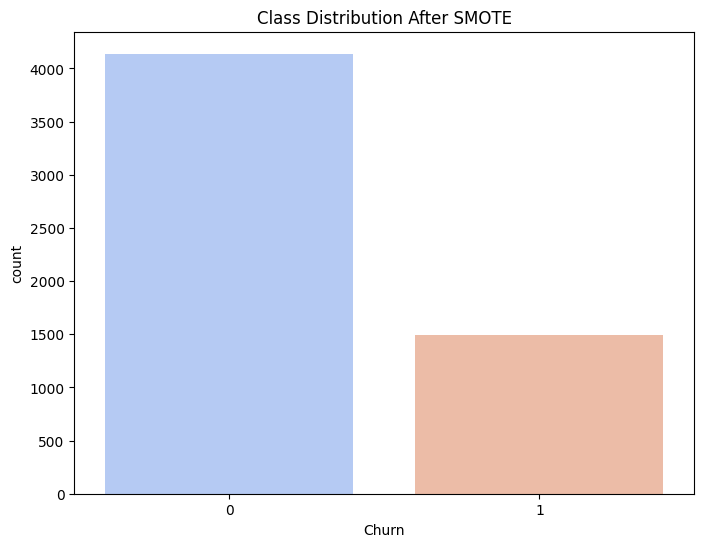

In [45]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train, palette='coolwarm')
plt.title("Class Distribution After SMOTE")
plt.show()

## After Oversampling 

C:\Users\raghu\AppData\Local\Temp\ipykernel_31704\3699928109.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=y_train_smote, palette='coolwarm')


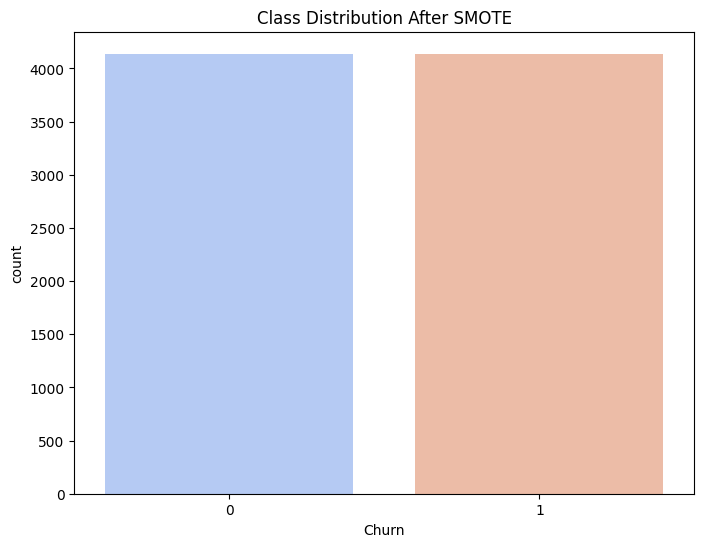

In [44]:
plt.figure(figsize=(8, 6))
sns.countplot(x=y_train_smote, palette='coolwarm')
plt.title("Class Distribution After SMOTE")
plt.show()

## Training the model

In [46]:
model = LogisticRegression(class_weight='balanced', random_state=42)
model.fit(X_train_smote, y_train_smote)

# Predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.73      0.81      1036
           1       0.52      0.83      0.64       373

    accuracy                           0.76      1409
   macro avg       0.72      0.78      0.73      1409
weighted avg       0.82      0.76      0.77      1409



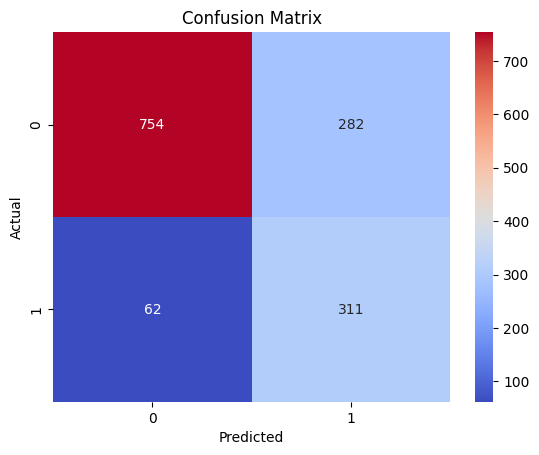

In [47]:
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="coolwarm")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

## ROC-AUC Curve 

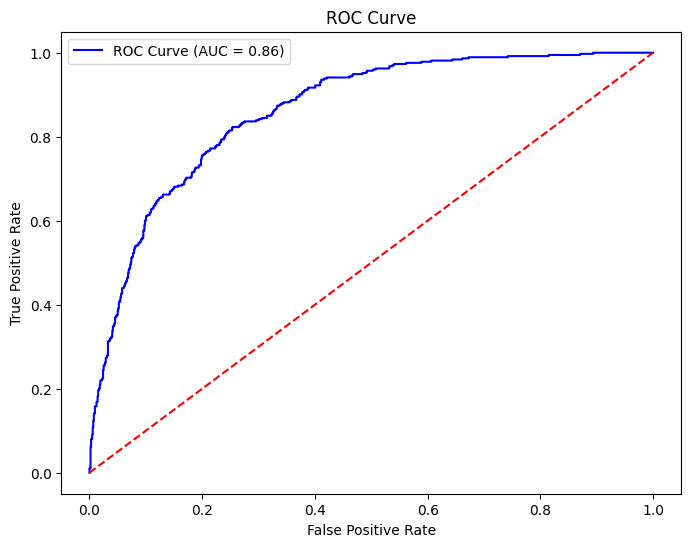

In [48]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f"ROC Curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()

## Precision - Recall Curve

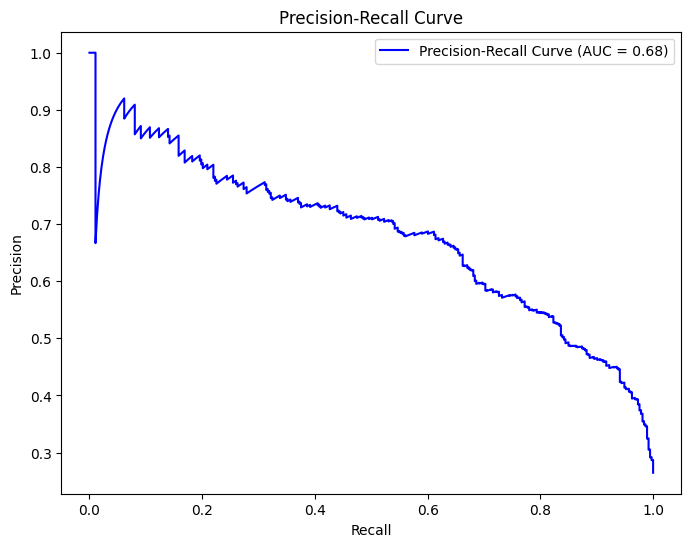

In [49]:
precision, recall, _ = precision_recall_curve(y_test, y_pred_proba)
pr_auc = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, color='blue', label=f"Precision-Recall Curve (AUC = {pr_auc:.2f})")
plt.title("Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()

# Section 5: Hyperparameter Tuning
## Experiment with class_weight and regularization


In [50]:

for c in [0.01, 0.1, 1, 10]:
    model = LogisticRegression(C=c, class_weight='balanced', random_state=42)
    model.fit(X_train_smote, y_train_smote)
    print(f"\nRegularization Strength (C={c}):")
    print("Training Accuracy:", model.score(X_train_smote, y_train_smote))
    print("Testing Accuracy:", model.score(X_test, y_test))



Regularization Strength (C=0.01):
Training Accuracy: 0.7663122281295311
Testing Accuracy: 0.7615330021291696

Regularization Strength (C=0.1):
Training Accuracy: 0.7719913001449976
Testing Accuracy: 0.7572746628814763

Regularization Strength (C=1):
Training Accuracy: 0.7713871435476075
Testing Accuracy: 0.7558552164655784

Regularization Strength (C=10):
Training Accuracy: 0.7721121314644755
Testing Accuracy: 0.7537260468417317
